In [154]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets 
from scipy.spatial import ConvexHull

data = datasets.load_iris() 
df = pd.DataFrame(data.data, columns=data.feature_names) 
df['Target'] = pd.DataFrame(data.target) 



In [155]:
def minmax(points, iter, key = lambda x: x[0]):
    mn = np.finfo(np.float64).max
    mx = np.finfo(np.float64).min
    for i in iter:
        if(mn > key(points[i])):
            mn = key(points[i])
            idmn = i
        if(mx < key(points[i])):
            mx = key(points[i])
            idmx = i
    return idmn, idmx

print(minmax([[1,2],[10,2],[-1,10],[11,11]], [0, 1, 2, 3]))

(2, 3)


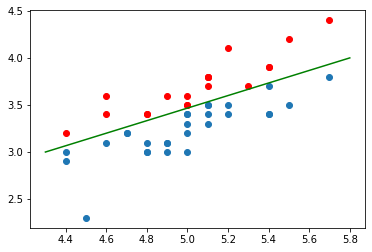

In [156]:
def classifyRegion(point, p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    xt, yt = point
    # buat persamaan garis ay = bx + c
    a = x2-x1
    b = y2-y1
    c = (x2-x1)*y1 - (y2-y1)*x1
    # 1 is above
    # 0 is in the line
    # -1 is below
    if(np.abs(a*yt-b*xt-c)<1e-9):
        return 0
    if(a*yt > b*xt + c):
        return 1
    else:
        return -1

points = df[df['Target'] == 0]
points = points.iloc[:,[0,1]].values
mn, mx = minmax(points, [i for i in range(len(points))])
s1 = np.array([i for i in range(len(points)) if classifyRegion(points[i], points[mn], points[mx])==1])
s2 = np.array([i for i in range(len(points)) if classifyRegion(points[i], points[mn], points[mx])==-1])
plt.scatter(points[s1, 0], points[s1, 1], color='r')
plt.scatter(points[s2, 0], points[s2, 1])
plt.plot(points[[mn, mx], 0], points[[mn, mx], 1], "g")


In [157]:
def mxNode(points, iter, p1, p2):
    def getDist(point):
        x1, y1 = p1
        x2, y2 = p2
        xt, yt = point
        # buat persamaan garis ay = bx + c
        a = x2-x1
        b = y2-y1
        c = (x2-x1)*y1 - (y2-y1)*x1
        denum = np.hypot(a, b)
        num = np.abs(a*yt - b*xt - c)
        return num/denum
    _, mx = minmax(points, iter, getDist)
    return mx

# p1 = points[mxNode(points, s1, points[mn], points[mx])]
# p2 = points[mxNode(points, s2, points[mn], points[mx])]

# plt.scatter(points[s1, 0], points[s1, 1])
# plt.scatter(points[s2, 0], points[s2, 1])
# plt.scatter(p1[0], p1[1], color = 'r')
# plt.scatter(p2[0], p2[1])
# plt.plot(points[[mn, mx], 0], points[[mn, mx], 1], "g")

In [158]:
def Hull(points, iter, p1, p2, solutions):
    if(len(iter)):
        mx = mxNode(points, iter, points[p1], points[p2])
        solutions.remove([p1, p2])
        solutions += [[p1, mx], [mx, p2]]
        s1 = np.array([i for i in iter if classifyRegion(points[i], points[p1], points[mx])==1])
        s2 = np.array([i for i in iter if classifyRegion(points[i], points[mx], points[p2])==1])
        # print(points[mx])
        # print(s1)
        # print(s2)
        # if(len(s1)):
        #     plt.scatter(points[s1, 0], points[s1, 1])
        # if(len(s2)):
        #     plt.scatter(points[s2, 0], points[s2, 1])
        solutions = Hull(points, s1, p1, mx, solutions)
        solutions = Hull(points, s2, mx, p2, solutions)
    return solutions
    

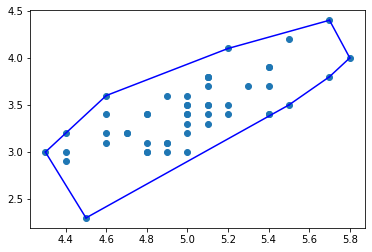

In [159]:
def MyConvexHull(points):
    iter = [_ for _ in range(len(points))]
    mn, mx = minmax(points, iter)
    solutions = [[mn, mx], [mx, mn]]
    s1 = np.array([i for i in range(len(points)) if classifyRegion(points[i], points[mn], points[mx])==1])
    s2 = np.array([i for i in range(len(points)) if classifyRegion(points[i], points[mn], points[mx])==-1])
    solutions = Hull(points, s1, mn, mx, solutions)
    solutions = Hull(points, s2, mx, mn, solutions)
    
    return solutions
colors = ['b','r','g']
hull = MyConvexHull(points)
plt.scatter(points[:, 0], points[:, 1], label=data.target_names[0])
for simplex in hull:
    x, y = simplex
    plt.plot(points[simplex, 0], points[simplex, 1], colors[0])

In [160]:
sx = set([(1,2), (2, 1)])
def change(sx):
    sx.remove((1,2))
print(sx)
change(sx)
print(sx)

{(1, 2), (2, 1)}
{(2, 1)}


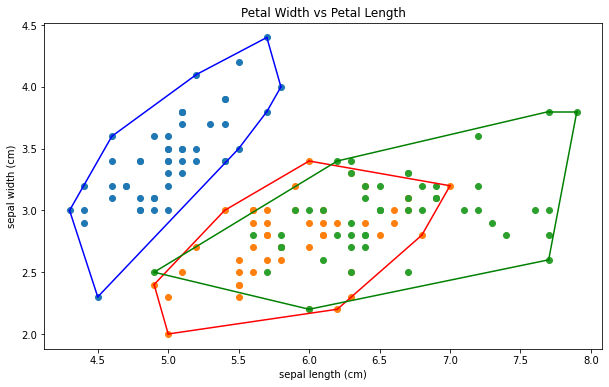

In [161]:
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(3):
    bucket = df[df['Target'] == i]
    bucket = bucket.iloc[:,[0,1]].values
    hull = MyConvexHull(np.array(bucket))
    plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
    for simplex in hull:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])

In [162]:
df = open("./tes.csv", "r")
print(type(df.read()))

<class 'str'>


In [163]:
Points = [[1.3,2],[2,3]]
Points = [Points[j]+[j] for j in range(len(Points))]
Points

[[1.3, 2, 0], [2, 3, 1]]